In [19]:
import numpy as np
import pandas as pd
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import matplotlib.pyplot as plt


In [24]:
stay_at_home_df = pd.read_csv("https://covid.ourworldindata.org/data/owid-covid-data.csv")
stay_at_home_df.head()
stay_at_home_df.columns
cleaned_stay_at_home_df = stay_at_home_df[['location','date','total_cases','total_tests','stringency_index','positive_rate','total_deaths']]
cleaned_stay_at_home_df
cleaned_stay_at_home_df['cases_per_tests_ratio'] = cleaned_stay_at_home_df['total_cases']/cleaned_stay_at_home_df['total_tests']
cleaned_stay_at_home_df
cleaned_stay_at_home_df.dtypes
groupby_location_df = cleaned_stay_at_home_df.groupby('location',as_index=False)
separated_location_df = dict(iter(groupby_location_df))
us_covid_df = separated_location_df['United States']

<ipython-input-24-976439e19f7f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_stay_at_home_df['cases_per_tests_ratio'] = cleaned_stay_at_home_df['total_cases']/cleaned_stay_at_home_df['total_tests']


In [69]:
us_prediction = us_covid_df[:-30]
us_prediction

,location,date,total_cases,total_tests,stringency_index,positive_rate,total_deaths,cases_per_tests_ratio
44033,United States,2019-12-31,0.0,NaN,NaN,NaN,0.0,NaN
44034,United States,2020-01-01,0.0,NaN,0.00,NaN,0.0,NaN
44035,United States,2020-01-02,0.0,NaN,0.00,NaN,0.0,NaN
44036,United States,2020-01-03,0.0,NaN,0.00,NaN,0.0,NaN
44037,United States,2020-01-04,0.0,NaN,0.00,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...
44274,United States,2020-08-28,5867785.0,87644326.0,67.13,0.050,180824.0,0.066950
44275,United States,2020-08-29,5917439.0,88506633.0,67.13,0.049,181773.0,0.066859
44276,United States,2020-08-30,5961582.0,89126574.0,67.13,0.049,182779.0,0.066889
44277,United States,2020-08-31,5997163.0,89825565.0,67.13,0.049,183069.0,0.066765


In [67]:
class MyClass:
    def __init__(self, series, fig):
        self.series = series
        self.figure = fig
        self.cid = self.figure.canvas.mpl_connect('button_press_event', self)

    def __call__(self, event):
        self.series.plot([us_prediction['date']], [us_prediction['total_cases']])  
        self.figure.canvas.draw()

def plot_metrics(forecast_cv,location, imgname):
    mse_plot = plot_cross_validation_metric(forecast_cv, metric = 'mse')
    mse_plot.savefig(f'./Seasonality_Comparison/{location}_mse_{imgname}')
                      
    rmse_plot =plot_cross_validation_metric(forecast_cv, metric = 'rmse')
    rmse_plot.savefig(f'./Seasonality_Comparison/{location}_rmse_{imgname}')
                      
    mae_plot = plot_cross_validation_metric(forecast_cv, metric = 'mae')
    mae_plot.savefig(f'./Seasonality_Comparison/{location}_mae_{imgname}')
                      
    mape_plot = plot_cross_validation_metric(forecast_cv, metric = 'mape')
    mae_plot.savefig(f'./Seasonality_Comparison/{location}_mape_{imgname}')
                      
                      
def plot_forecast(forecast,m,location,img_name):
    forecastplot = m.plot(forecast)
    forecastplot.savefig(f'./Seasonality_Comparison/{location}_forecast_{img_name}')
    
    plot_components = m.plot_components(forecast)
    plot_components.savefig(f'./Seasonality_Comparison/{location}_components_{img_name}')
                             
                             

def prophet_predicts(location_df,location, yearly_seasonality, weekly_seasonality):
    print(location_df.columns)
    num_rows = str(location_df.shape[0] - 31) + ' days'
    prophet_df = location_df[['date','total_cases']]
    prophet_df = prophet_df.rename(columns={'date':'ds','total_cases': 'y'})
    m = Prophet(interval_width = 0.95, yearly_seasonality = yearly_seasonality, weekly_seasonality = weekly_seasonality)
    m.fit(prophet_df)
    future = m.make_future_dataframe(periods=30)
    forecast = m.predict(future)
    forecast_cv = cross_validation(m, initial = num_rows, period = '30 days', horizon = '30 days' ) # of rows - 31 days
    forecast_df = pd.DataFrame(forecast_cv)
    file_name = 'daily'
    if(yearly_seasonality):
        file_name = 'yearly_' + file_name
        
    if(weekly_seasonality):
        file_name = 'weekly_' + file_name
    
    
    forecast_df.to_csv(f'predicted_{file_name}.csv')
    

#     plot_forecast(forecast,m, location, img_name)
#     plot_metrics(forecast_cv, location, img_name)

In [68]:
prophet_predicts(us_prediction, 'United_States', yearly_seasonality = True, weekly_seasonality = False) 

prophet_predicts(us_prediction, 'United_States', yearly_seasonality = False, weekly_seasonality = False)

prophet_predicts(us_prediction, 'United_States', yearly_seasonality = False, weekly_seasonality = True) 

prophet_predicts(us_prediction, 'United_States', yearly_seasonality = True,  weekly_seasonality = True)
# forecast_dfs[0].to_csv('predicted_yearly_weekly.csv')



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Index(['location', 'date', 'total_cases', 'total_tests', 'stringency_index',
       'positive_rate', 'total_deaths', 'cases_per_tests_ratio'],
      dtype='object')


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-09-01 00:00:00 and 2020-09-01 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Index(['location', 'date', 'total_cases', 'total_tests', 'stringency_index',
       'positive_rate', 'total_deaths', 'cases_per_tests_ratio'],
      dtype='object')


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-09-01 00:00:00 and 2020-09-01 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Index(['location', 'date', 'total_cases', 'total_tests', 'stringency_index',
       'positive_rate', 'total_deaths', 'cases_per_tests_ratio'],
      dtype='object')


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-09-01 00:00:00 and 2020-09-01 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Index(['location', 'date', 'total_cases', 'total_tests', 'stringency_index',
       'positive_rate', 'total_deaths', 'cases_per_tests_ratio'],
      dtype='object')


INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-09-01 00:00:00 and 2020-09-01 00:00:00


In [138]:
us_join = us_prediction[:-30]
us_join.shape

(215, 8)

In [139]:
forecast_dfs[0]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-08-02,4.484069e+06,4.404893e+06,4.556888e+06,4620444.0,2020-08-01
1,2020-08-03,4.536675e+06,4.461733e+06,4.614419e+06,4667955.0,2020-08-01
2,2020-08-04,4.589636e+06,4.511375e+06,4.670260e+06,4713562.0,2020-08-01
3,2020-08-05,4.644685e+06,4.563468e+06,4.725630e+06,4771087.0,2020-08-01
4,2020-08-06,4.700427e+06,4.624459e+06,4.778472e+06,4823891.0,2020-08-01
5,2020-08-07,4.757801e+06,4.679140e+06,4.842249e+06,4883646.0,2020-08-01
6,2020-08-08,4.815148e+06,4.738716e+06,4.895842e+06,4941796.0,2020-08-01
7,2020-08-09,4.867407e+06,4.783746e+06,4.952940e+06,4998017.0,2020-08-01
8,2020-08-10,4.920013e+06,4.833570e+06,5.014387e+06,5044864.0,2020-08-01
9,2020-08-11,4.972974e+06,4.885735e+06,5.067232e+06,5094394.0,2020-08-01


In [140]:
forecast_dfs[0]['ds'].shape

(30,)

In [141]:
us_join['date', 'total_cases']

KeyError: ('date', 'total_cases')

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


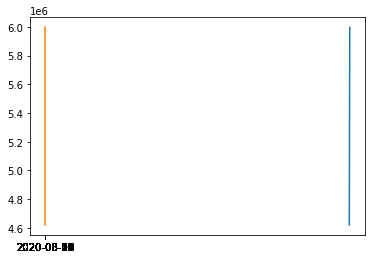

In [101]:
plt.plot(forecast_dfs[0]['ds'],forecast_dfs[0]['y'])
plt.plot(us_prediction['date'][-30:],us_prediction['total_cases'][-30:])

Help on list object:

class list(object)
 |  list(iterable=(), /)
 |  
 |  Built-in mutable sequence.
 |  
 |  If no argument is given, the constructor creates a new empty list.
 |  The argument must be an iterable if specified.
 |  
 |  Methods defined here:
 |  
 |  __add__(self, value, /)
 |      Return self+value.
 |  
 |  __contains__(self, key, /)
 |      Return key in self.
 |  
 |  __delitem__(self, key, /)
 |      Delete self[key].
 |  
 |  __eq__(self, value, /)
 |      Return self==value.
 |  
 |  __ge__(self, value, /)
 |      Return self>=value.
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __getitem__(...)
 |      x.__getitem__(y) <==> x[y]
 |  
 |  __gt__(self, value, /)
 |      Return self>value.
 |  
 |  __iadd__(self, value, /)
 |      Implement self+=value.
 |  
 |  __imul__(self, value, /)
 |      Implement self*=value.
 |  
 |  __init__(self, /, *args, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate sign

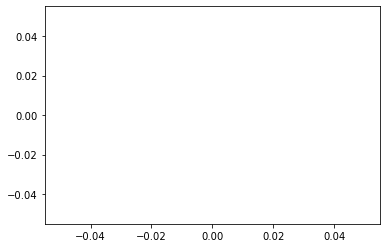

In [84]:
help(plt.plot())